In [ ]:
 # import os
import io
from google.colab import files
##camel
import camel_tools
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer
from camel_tools.utils.dediac import dediac_ar

import json
import math
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


import nltk
from bs4 import BeautifulSoup
import html
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
nltk.download('stopwords')
nltk.download('punkt')
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

#evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,precision_score, recall_score, f1_score, ConfusionMatrixDisplay


#lru
from functools import lru_cache


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Add `%load_ext cudf.pandas` before importing pandas to speed up operations using GPU

In [ ]:
uploaded = files.upload()

Saving articles_prepares_balanced_10000.csv to articles_prepares_balanced_10000 (2).csv


In [ ]:
print(uploaded.keys())


dict_keys(['articles_prepares_balanced_10000 (1).csv'])


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['articles_prepares_balanced_10000 (1).csv']))
print(df.head())
print(df['label'].value_counts())

   label                                            content
0      1  تدوينة غاضمة من الحارس محمد أبو جبل قبل موقعة ...
1      0  الأردن..السر فى اختلاف زي الملك وولي عهده بصرح...
2      0  اخبار السعودية: نساء صم الشرقية يحتفون بالمرأة...
3      0  قتيلان بانهيار مدرجات في كنيس يهودي قرب القدس ...
4      0  9 معلومات عن دعم المؤسسة الدولية للتنمية للدول...
label
1    5000
0    5000
Name: count, dtype: int64


In [ ]:
print(df["content"][4])

9 معلومات عن دعم المؤسسة الدولية للتنمية للدول الفقيرة على رأسها اليمن شكرا لقرائتكم خبر عن 9 معلومات عن دعم المؤسسة الدولية للتنمية للدول الفقيرة على رأسها اليمن والان مع تفاصيل الخبر

القاهرة - سامية سيد - أعلن البنك الدولى وعدد من المؤسسات التابعة على رأسها مؤسسة التمويل الدولية تخصيص نحو 100 مليون دولار منح لإنقاذ الشعب اليمنى من الظروف اللاإنسانية التي يعيشها.

وأشار البنك أنه بعد سنوات من الحرب الأهلية، يحتاج ملايين من اليمنيين بشدة إلى الغذاء والمأوى والرعاية الصحية، وعددا من التفاصيل كتالي..

1 - أعلن البنك الدولى وعدد من المؤسسات التابعة على رأسها مؤسسة التمويل الدولية تخصيص نحو 100 مليون دولار منح.

2 - يحتاج ملايين من اليمنيين بشدة إلى الغذاء والمأوى والرعاية الصحية.

3 - أدى الصراع المستمر منذ عام 2015 في اليمن وهو بالفعل أفقر بلد في منطقة الشرق الأوسط وشمال أفريقيا إلى إبقاء اليمن في أزمة طاحنة.

4 - أدت جائحة كورونا إلى تمزيق أنظمة الحماية الاجتماعية والطبية التي كانت تعاني من ضعف بالفعل.

5 - تشير تقديرات مكتب الأمم المتحدة إلى أن الصراعات العنيفة في جميع أنحاء العالم وص

In [ ]:
#remove html tags
def clean_text_robust(text):
    if pd.isna(text):
        return text
    # Remove well-formed HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    # Decode HTML entities like &lt;, &gt;
    text = html.unescape(text)
    # Remove all remaining <...> patterns (not just HTML)
    text = re.sub(r'<[^<>]*>', '', text)
    # Optionally remove other decorative patterns (e.g., <<**, §§////, etc.)
    text = re.sub(r'[<>«»]', '', text)
    return text.strip()

In [ ]:
#suppression des caracteres speciaux:
def remove_special_characters(text):
    # This keeps Arabic letters (\u0600-\u06FF), digits, and whitespace
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)  # keep only Arabic chars
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

In [ ]:
#Normalisation
def normalization(text):
    text = re.sub(r'[إأآٱ]', 'ا', text)
    # Remove duplicate alefs (e.g., "ااالمناخ" → "المناخ")
    text = re.sub(r'ا{2,}', 'ا', text)
    # Normalize other characters
    text = re.sub(r'ى', 'ي', text)
    text = re.sub(r'ؤ', 'و', text)
    text = re.sub(r'ئ', 'ي', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'ـ', '', text)
    text = re.sub(r'[ًٌٍَُِّْ]', '', text)  # Tashkeel
    text = re.sub(r'[^\w\s]', '', text)     # Punctuation
    text = re.sub(r'\d+', '', text)         # Digits
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [ ]:
def tokenization(text):
    if not isinstance(text, str):
        return []
    return simple_word_tokenize(text)


In [ ]:
@lru_cache()
def get_normalized_stopwords():
    raw = stopwords.words('arabic')
    return set(normalization(w) for w in raw)


In [ ]:
# Tokenisation et filtrage

def eliminate_stopwords(tokens):
    stopwords_set = get_normalized_stopwords()
    return [w for w in tokens if w not in stopwords_set]


In [ ]:
db = MorphologyDB.builtin_db()
analyzer = Analyzer(db)
@lru_cache(maxsize=10000)
def cached_stem(word):
    # word is already normalized before stemming
    analyses = analyzer.analyze(word)
    if analyses:
        all_stems = [dediac_ar(a['stem']) for a in analyses if 'stem' in a]
        return min(all_stems, key=len) if all_stems else word
    return word


In [ ]:
# Charger la base de données et initialiser une seule fois


# Fonction principale de stemming
def stemming(tokens):
    return [cached_stem(word) for word in tokens]



In [ ]:
def normalize_alef(text):
    return re.sub(r'[إأآٱ]', 'ا', text)

In [ ]:



def preprocess_pipeline(text):
    cleaned = clean_text_robust(text)
    no_specials = remove_special_characters(cleaned)
    normalized = normalization(no_specials)
    tokens = tokenization(normalized)
    no_stops = eliminate_stopwords(tokens)
    stems = stemming(no_stops)
    # Apply alef normalization again after stemming
    stems = [normalize_alef(term) for term in stems]
    return ' '.join(stems)

df['content'] = df['content'].apply(preprocess_pipeline)


In [ ]:
print(df.head())

   label                                            content
0      1  دو غاضمه حارس محمد جبل موقع ترجي محمد جبل شر ح...
1      0  الاردنالسر اختلاف زي ملك ولى عهد صرح شهيد زيار...
2      0  اخبار سعودي ساء صم شرقي حتف مرا يوم عالمي نظم ...
3      0  قتيل انهيار مدرج كنيس يهود قرب قدس سفر انهيار ...
4      0  معلوم دعم الموسسه دولي تنمي دول فقير راس يمن ش...


In [ ]:
print(df["content"][0])

الاردنالسر اختلاف زي ملك ولى عهد صرح شهيد زيار اضرح المستقلهاحمد عبدالله كد مصدر اردن مطلع عاهل اردني ملك عبد الله ثاني ولى عهد امير حسين زور اضرح بز احتفال حضر صرح شهيد مناسب ميويه دول ين مصدر اتي سبب ارتباط باس عرش مناسب محدد جه شار لواء متقاعد عود الشديفات زي ملك عبد الله ثاني ولى عهد خلال زيار صرح شهيد احد رتبط مراسم زيار موضح زي ارتد عاهل اردني ولى عهد خلال زيار صرح شهيد زي عرش رتدي ملك عبد الله ثاني القاء خطب عرش مجلس ام في مناسب طابع رسمي جلال ملك عبدالله ثاني سمو امير حسين بن عبدالله ثاني لي عهد اصحاب سمو امراء حسن بن طلال فيصل بن حسين وعل بن حسين حمز بن حسين هاشم بن حسين طلال بن محمد غاز بن محمد راشد بن حسن يقروون فاتح روح مغفور جلال ملك حسين قال زي دلال مرتبط تاريخ مملك وميويه تاسيس حمل يوم دلال رمز تمثل ح عرش شهداء وطن عن زي لي عهد خلال زيار كد الشديفات زي دركي رسمي سمو لي عهد عتلي وشاح احمر رتبط امكن مناسب محدد ين لي عهد خلع وشاح زيار اضرح ملكي موضح وشاح تعلق استقلال دول رتدي زي عسكري خلال وجود امير صرح شهيد احتفال عيد جيش وميويه دول اردني


In [ ]:
df.tail()

,label,content
9995,1,جونسون ستبعد شر قو بريطاني يمن جونسون متابع قا...
9996,1,وزير فلاح اسعار بطاطا معقول والجزاير حقق اكتفا...
9997,1,طبيب سيراميكا كليوباترا كشف تفاصيل اصاب عامر ع...
9998,0,بغداد عد صالح سكن زراع عراقي كشف سبب دب محمود ...
9999,1,استعراض اسراييلي موقف فلسطيني اتفاقي تطبيع قال...


In [ ]:

def split_dataset(df, test_size=0.2, random_state=42):
    X = df['content']
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

# Exemple d'utilisation
X_train, X_test, y_train, y_test = split_dataset(df)


#ATCF-IDF

In [ ]:
from tqdm import tqdm  # Import tqdm

# ———  TCFIDF implementation ———

def calculate_doc_freqs(docs):
    df = Counter()
    for doc in tqdm(docs, desc="Calculating document frequencies"):  # Add tqdm here
        for t in set(doc):
            df[t] += 1
    return df

def compute_idf_vector(df, n_docs, eps=1e-9):
    return { term: math.log(n_docs / (freq + eps))
             for term, freq in df.items() }

def calculate_term_occurrences_in_category(term, cat, docs, categories):
    Nk = sum(1 for c in categories if c == cat)
    if Nk == 0:
        return 0.0
    count = sum(1 for d, c in zip(docs, categories)
                  if c == cat and term in d)
    return count / Nk

def build_atcf_matrix(docs, categories, vocab):
    n_docs, n_terms = len(docs), len(vocab)
    term_to_idx = {t:i for i,t in enumerate(vocab)}
    cats = set(categories)

    # Precompute P(term|category) with tqdm progress bar
    occ_ratio = {}
    for t in tqdm(vocab, desc="Calculating term-category occurrences"):  # Add tqdm here
        for c in cats:
            occ_ratio[(t, c)] = calculate_term_occurrences_in_category(t, c, docs, categories)

    ATCF = np.zeros((n_docs, n_terms), dtype=float)
    for d_idx, (doc, cat) in tqdm(enumerate(zip(docs, categories)), desc="Building ATCF matrix", total=n_docs):  # Add tqdm here
        Nd = len(doc) or 1
        freqs = Counter(doc)
        for term, f in freqs.items():
            if term in term_to_idx:
                t_idx = term_to_idx[term]
                ATCF[d_idx, t_idx] = (f * occ_ratio[(term, cat)]) / Nd
    return ATCF,occ_ratio

def build_tcfidf_matrix(docs, categories):
    n_docs = len(docs)

    # 1) vocabulary
    vocab = sorted({t for doc in docs for t in doc})

    # 2) IDF
    dfreq = calculate_doc_freqs(docs)
    idf   = compute_idf_vector(dfreq, n_docs)

    # 3) ATCF
    ATCF, occ_ratio = build_atcf_matrix(docs, categories, vocab)

    # 4) ATCF × IDF
    idf_vec = np.array([idf[t] for t in vocab])
    TCFIDF = ATCF * idf_vec[np.newaxis, :]

    return TCFIDF, vocab, idf, occ_ratio


def transform_tcfidf_matrix(docs, categories, vocab, idf, occ_ratio):
    n_docs = len(docs)
    n_terms = len(vocab)
    term_to_idx = {t: i for i, t in enumerate(vocab)}
    TCFIDF = np.zeros((n_docs, n_terms), dtype=float)
    for d_idx, (doc, cat) in tqdm(enumerate(zip(docs, categories)), desc="Transforming TCFIDF for test set", total=n_docs):
        Nd = len(doc) or 1
        freqs = Counter(doc)
        for term, f in freqs.items():
            if term in term_to_idx and (term, cat) in occ_ratio:
                t_idx = term_to_idx[term]
                tf = (f * occ_ratio[(term, cat)]) / Nd
                TCFIDF[d_idx, t_idx] = tf * idf[term]
    return TCFIDF

# ——— Main usage ———

if __name__ == "__main__":
    # Tokenize content
    tokens_train = X_train.apply(tokenization)
    tokens_test = X_test.apply(tokenization)

    # Convert to lists
    docs_train = tokens_train.tolist()
    categories_train = y_train.tolist()

    docs_test = tokens_test.tolist()
    categories_test = y_test.tolist()

    # Build TCFIDF for training set
    tcfidf_matrix_train, vocabulary_train, idf_train, occ_ratio_train = build_tcfidf_matrix(docs_train, categories_train)

    # Transform test set using training vocabulary, idf, and occurrence ratios
    tcfidf_matrix_test = transform_tcfidf_matrix(docs_test, categories_test, vocabulary_train, idf_train, occ_ratio_train)

    # Inspect
    print("Train matrix shape (n_docs × n_terms):", tcfidf_matrix_train.shape)
    print("Test matrix shape (n_docs × n_terms):", tcfidf_matrix_test.shape)
    print("First 10 vocabulary terms:", vocabulary_train[:10])
    print("First row of TCFIDF (train):", tcfidf_matrix_train[0])


Transforming TCFIDF for test set: 100%|██████████| 2000/2000 [00:01<00:00, 1501.14it/s]

Train matrix shape (n_docs × n_terms): (8000, 40025)
Test matrix shape (n_docs × n_terms): (2000, 40025)
First 10 vocabulary terms: ['ءحسب', 'اب', 'ابا', 'اباء', 'ابابا', 'اباتشي', 'اباح', 'اباحي', 'اباد', 'ابار']
First row of TCFIDF (train): [0. 0. 0. ... 0. 0. 0.]


In [ ]:
print("First 10 vocabulary terms:", vocabulary_train[0:-30])

First 10 vocabulary terms: ['ءحسب', 'اب', 'ابا', 'اباء', 'ابابا', 'اباتشي', 'اباح', 'اباحي', 'اباد', 'ابار', 'ابارتهايد', 'ابازيد', 'اباسكال', 'اباسينيا', 'اباضي', 'اباظه', 'اباغسطس', 'اباكار', 'اباكوس', 'ابالس', 'اباليس', 'ابان', 'ابانمي', 'اباوهم', 'اباينا', 'ابايه', 'ابايها', 'ابايهم', 'ابايي', 'ابتاع', 'ابتدا', 'ابتداء', 'ابتداع', 'ابتدايي', 'ابتداييا', 'ابتداييه', 'ابتدع', 'ابتزاز', 'ابتسام', 'ابتسم', 'ابتع', 'ابتعاث', 'ابتعاثهم', 'ابتعاد', 'ابتعد', 'ابتعدي', 'ابتغاء', 'ابتكار', 'ابتكاري', 'ابتكر', 'ابتلاء', 'ابتلاع', 'ابتلاعه', 'ابتلاعها', 'ابتلايه', 'ابتهاج', 'ابتهال', 'ابتهج', 'ابتياع', 'ابثثت', 'ابجد', 'ابجدي', 'ابح', 'ابحاث', 'ابحار', 'ابحث', 'ابحر', 'ابخر', 'ابخس', 'ابد', 'ابدا', 'ابداء', 'ابداع', 'ابداعي', 'ابدال', 'ابدع', 'ابدلايد', 'ابدوكل', 'ابدي', 'ابر', 'ابراء', 'ابراج', 'ابرار', 'ابراز', 'ابراش', 'ابرام', 'ابراموفيتش', 'ابراهام', 'ابراهيم', 'ابراهيموفيتش', 'ابراهيمي', 'ابردين', 'ابرز', 'ابرش', 'ابرق', 'ابرك', 'ابرم', 'ابرياء', 'ابريزي', 'ابريق', 'ابريل', 'ابريلالمالكي

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix", cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=cmap)
    plt.title(title)
    plt.show()

In [ ]:

def evaluate_model(y_true, y_pred, average='binary'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


In [ ]:
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, cmap):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, model.classes_, f"{model_name} - Confusion Matrix", cmap)
    return model


In [ ]:
def plot_decision_tree(model, feature_names, class_names, max_depth=3):
    plt.figure(figsize=(20, 10))
    plot_tree(model, filled=True, feature_names=feature_names, class_names=class_names, max_depth=max_depth)
    plt.show()


Accuracy: 0.6725
Precision: 0.6829
Recall: 0.6440
F1 Score: 0.6629

Confusion Matrix:
 [[701 299]
 [356 644]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1000
           1       0.68      0.64      0.66      1000

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



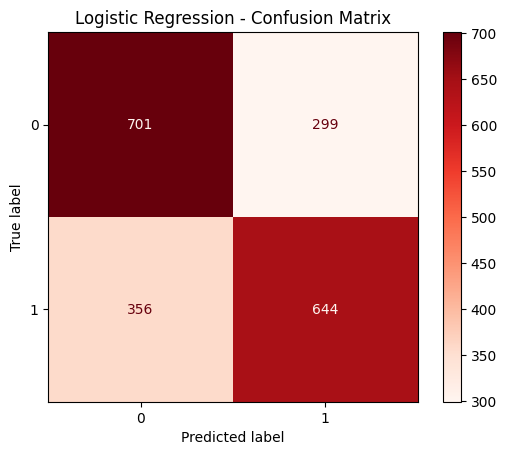

In [ ]:
# Logistic Regression
logreg_clf = train_and_evaluate_model(LogisticRegression(max_iter=1000, random_state=42),
                                      "Logistic Regression", tcfidf_matrix_train, y_train,
                                      tcfidf_matrix_test, y_test, plt.cm.Reds)


Accuracy: 0.7375
Precision: 0.7368
Recall: 0.7390
F1 Score: 0.7379

Confusion Matrix:
 [[736 264]
 [261 739]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1000
           1       0.74      0.74      0.74      1000

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



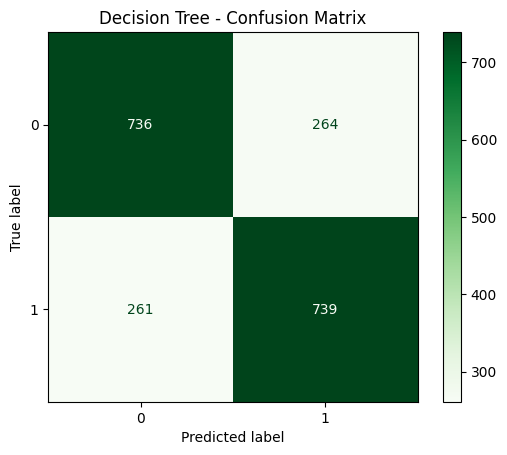

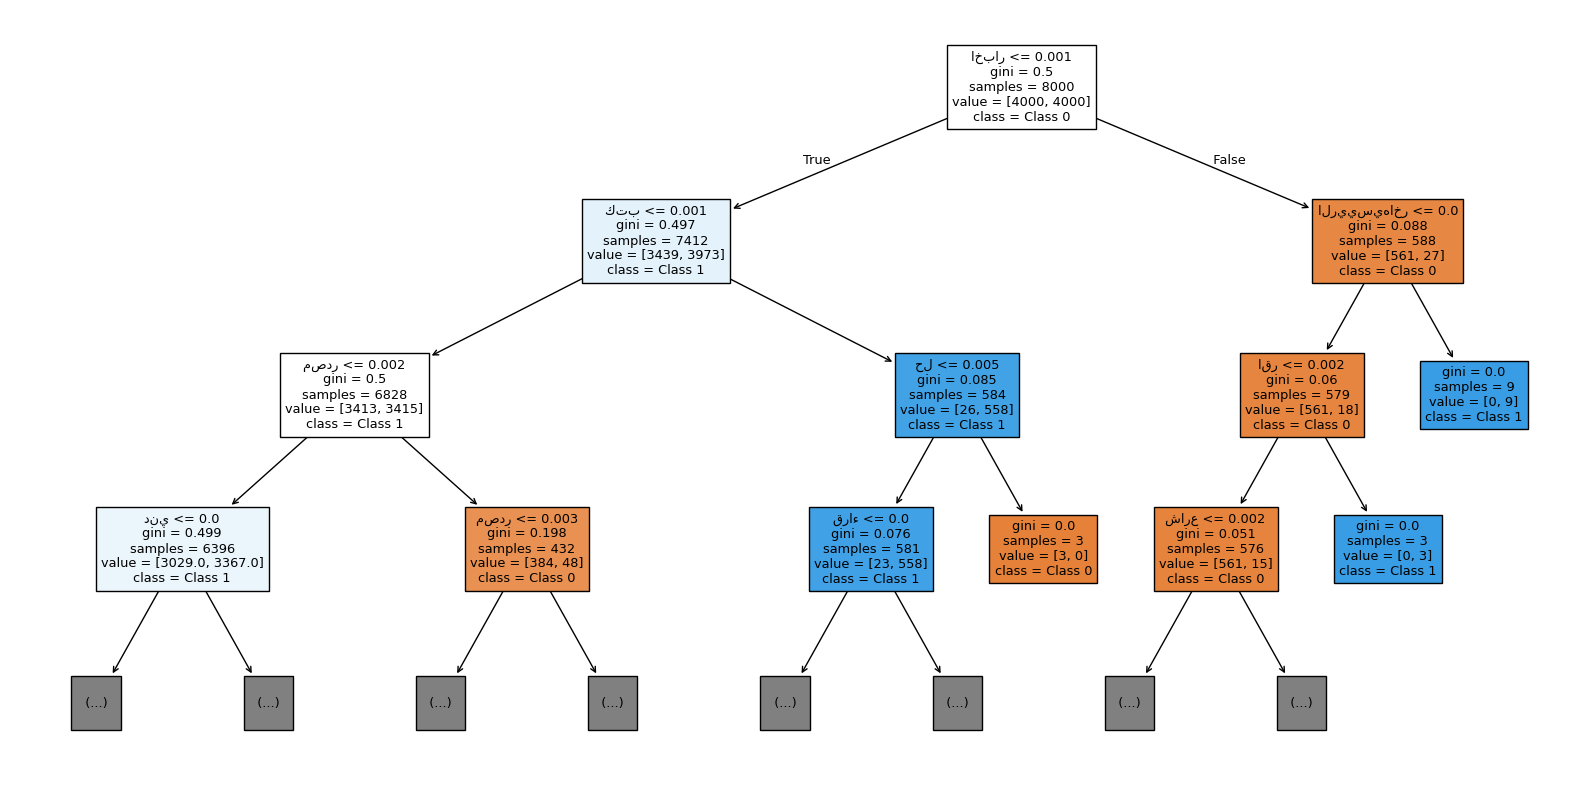

In [ ]:
# Decision Tree
dt_clf = train_and_evaluate_model(DecisionTreeClassifier(random_state=42),
                                  "Decision Tree", tcfidf_matrix_train, y_train,
                                  tcfidf_matrix_test, y_test, plt.cm.Greens)
plot_decision_tree(dt_clf, vocabulary_train, ['Class 0', 'Class 1'])



Accuracy: 0.6745
Precision: 0.6537
Recall: 0.7420
F1 Score: 0.6951

Confusion Matrix:
 [[607 393]
 [258 742]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.61      0.65      1000
           1       0.65      0.74      0.70      1000

    accuracy                           0.67      2000
   macro avg       0.68      0.67      0.67      2000
weighted avg       0.68      0.67      0.67      2000



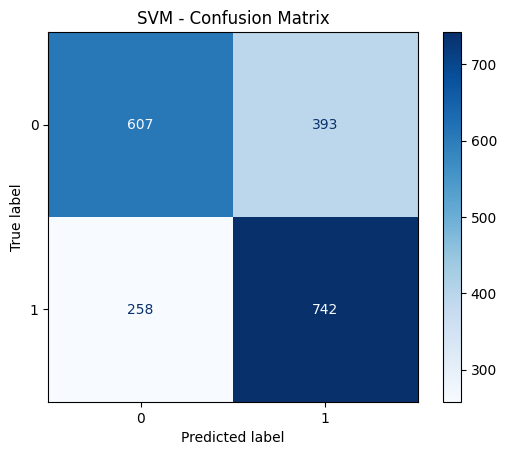

In [ ]:
# SVM
svm_clf = train_and_evaluate_model(SVC(kernel='linear', random_state=42),
                                   "SVM", tcfidf_matrix_train, y_train,
                                   tcfidf_matrix_test, y_test, plt.cm.Blues)



Accuracy: 0.8265
Precision: 0.8455
Recall: 0.7990
F1 Score: 0.8216

Confusion Matrix:
 [[854 146]
 [201 799]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.85      0.80      0.82      1000

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



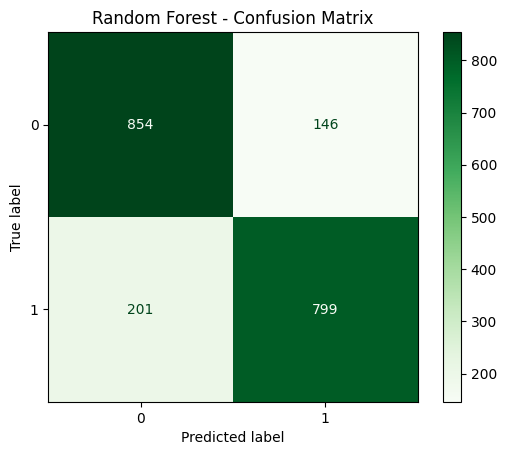

In [ ]:
# Random Forest
rf_clf = train_and_evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42),
                                  "Random Forest", tcfidf_matrix_train, y_train,
                                  tcfidf_matrix_test, y_test, plt.cm.Greens)



Accuracy: 0.6140
Precision: 0.5655
Recall: 0.9840
F1 Score: 0.7182

Confusion Matrix:
 [[244 756]
 [ 16 984]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.24      0.39      1000
           1       0.57      0.98      0.72      1000

    accuracy                           0.61      2000
   macro avg       0.75      0.61      0.55      2000
weighted avg       0.75      0.61      0.55      2000



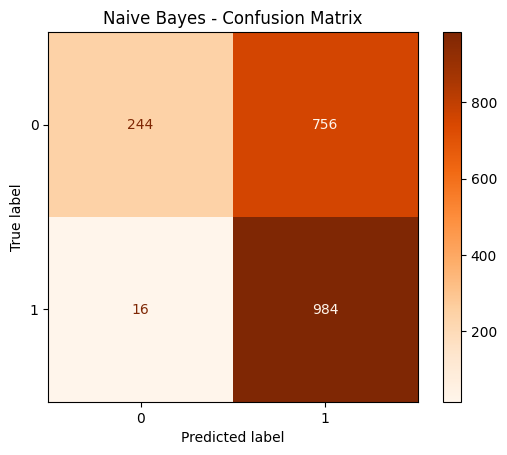

In [ ]:
# Naive Bayes
nb_clf = train_and_evaluate_model(MultinomialNB(),
                                  "Naive Bayes", tcfidf_matrix_train, y_train,
                                  tcfidf_matrix_test, y_test, plt.cm.Oranges)


Accuracy: 0.6785
Precision: 0.6869
Recall: 0.6560
F1 Score: 0.6711

Confusion Matrix:
 [[701 299]
 [344 656]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.70      0.69      1000
           1       0.69      0.66      0.67      1000

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



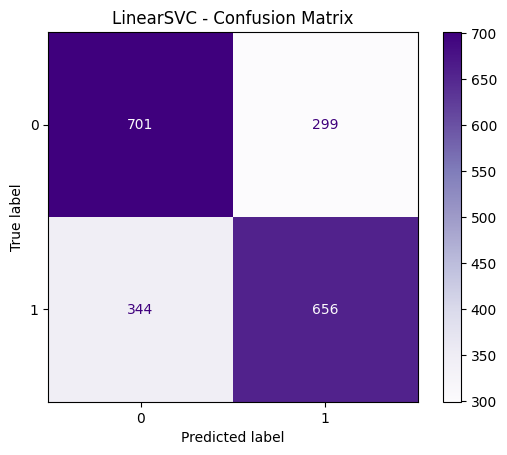

In [ ]:
# LinearSVC
linear_svc_clf = train_and_evaluate_model(LinearSVC(random_state=42),
                                          "LinearSVC", tcfidf_matrix_train, y_train,
                                          tcfidf_matrix_test, y_test, plt.cm.Purples)


#TF-IDF

In [ ]:

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))


X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("\nTF-IDF Vocabulary (word to index):")
print(tfidf.vocabulary_)

# 5. Now, you can use X_train_tfidf, X_test_tfidf, train_df['label'], test_df['label'] for modeling

# Example: Show samples and shapes
print("Sample processed training data (text and label):")

print("\nShape of X_train_tfidf:", X_train_tfidf.shape)

print("\nSample TF-IDF vectors (first 5 samples):" \
"")
print(X_train_tfidf[:5].toarray())


TF-IDF Vocabulary (word to index):
{'محافظ': 7841, 'بورسعيد': 2044, 'اسك': 597, 'نواب': 9429, 'انفاق': 1585, 'ملايين': 8725, 'وحد': 9666, 'سكني': 4970, 'قال': 6798, 'لواء': 7511, 'عادل': 5908, 'غضب': 6494, 'تم': 2664, 'مجال': 7771, 'موضح': 9053, 'دول': 4141, 'تحمل': 2241, 'قانون': 6838, 'مجتمع': 7779, 'تخصيص': 2256, 'اراضي': 363, 'تعاون': 2489, 'وزير': 9719, 'تنمي': 2810, 'محلي': 7917, 'محمود': 7935, 'شعراوي': 5327, 'ورييس': 9695, 'وزراء': 9709, 'مهندس': 8955, 'مصطف': 8388, 'مدبولي': 8008, 'خلال': 3856, 'اجتماع': 118, 'جن': 3159, 'ادار': 309, 'مليون': 8764, 'تابع': 2102, 'تعاوني': 2502, 'طلب': 5831, 'تقدم': 2596, 'استجاب': 482, 'هذا': 9525, 'حق': 3551, 'حقوق': 3560, 'مصري': 8384, 'مواطن': 8981, 'مضيف': 8423, 'عبر': 6057, 'حجم': 3380, 'انجاز': 1529, 'رض': 4429, 'واقع': 9626, 'ذل': 4232, 'وجه': 9658, 'شكر': 5351, 'قترح': 6881, 'انهاء': 1606, 'مشكل': 8329, 'عامل': 6002, 'صناديق': 5627, 'خاص': 3737, 'شهد': 5400, 'مجلس': 7796, 'رياس': 4557, 'النايب': 1320, 'حمد': 3638, 'تاكيد': 2127, 'بناء

<ipython-input-27-346b52e8ba28>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


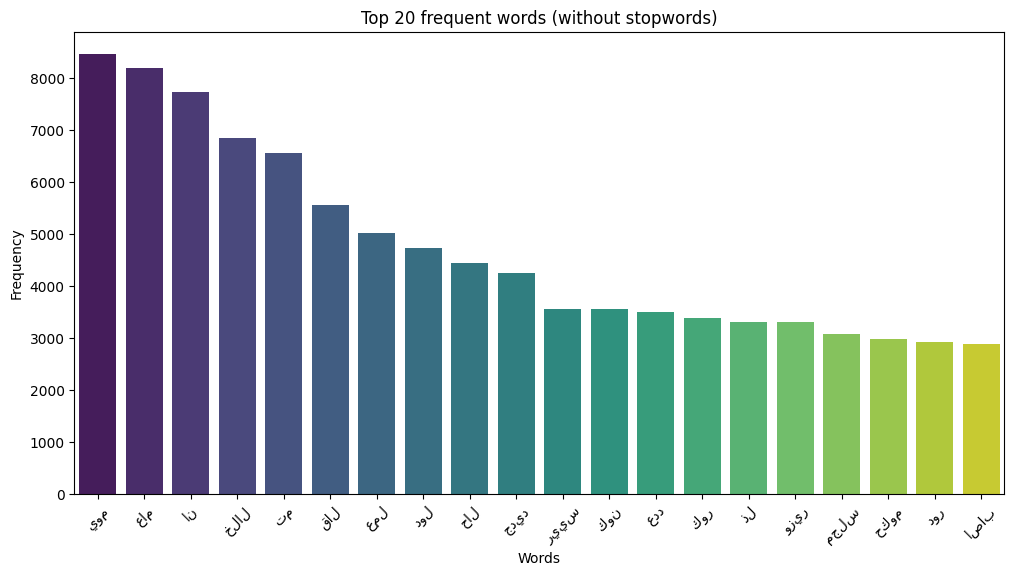

In [ ]:

# Combine all texts
all_text = ' '.join(X_train.astype(str).tolist())

# Split into words (tokens)
words = all_text.split()

# Count frequencies
word_freq = Counter(words)

# Remove stopwords (example, you can customize your list)
stopwords = {'و', 'في', 'على', 'من', 'أن', 'إن', 'لا', 'ما', 'هو', 'هي'}  # some common Arabic stopwords
filtered_word_freq = {w: c for w, c in word_freq.items() if w not in stopwords}

# Get top 20 words
top_words = sorted(filtered_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]

words, counts = zip(*top_words)

# Plot histogram
plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.xticks(rotation=45)
plt.title("Top 20 frequent words (without stopwords)")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show()


Accuracy: 0.6900
Precision: 0.6959
Recall: 0.6750
F1 Score: 0.6853

Confusion Matrix:
 [[705 295]
 [325 675]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      1000
           1       0.70      0.68      0.69      1000

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000



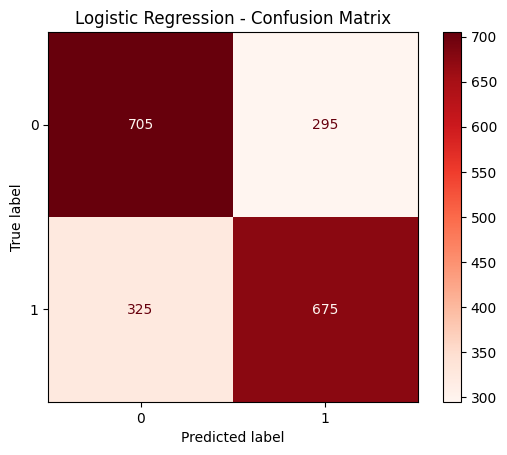

In [ ]:
# Logistic Regression
logreg_clf = train_and_evaluate_model(LogisticRegression(max_iter=1000, random_state=42),
                                      "Logistic Regression",X_train_tfidf, y_train,
                                      X_test_tfidf, y_test, plt.cm.Reds)

Accuracy: 0.6985
Precision: 0.6979
Recall: 0.7000
F1 Score: 0.6990

Confusion Matrix:
 [[697 303]
 [300 700]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1000
           1       0.70      0.70      0.70      1000

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



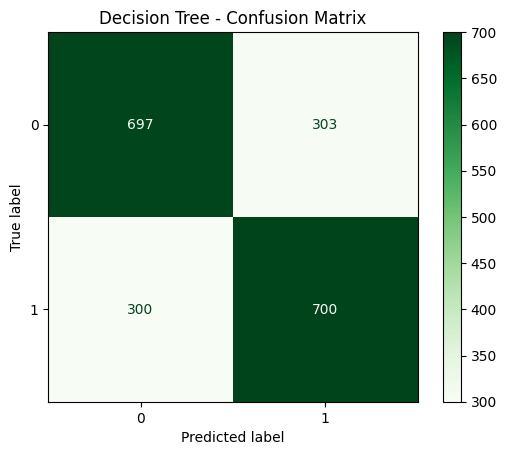

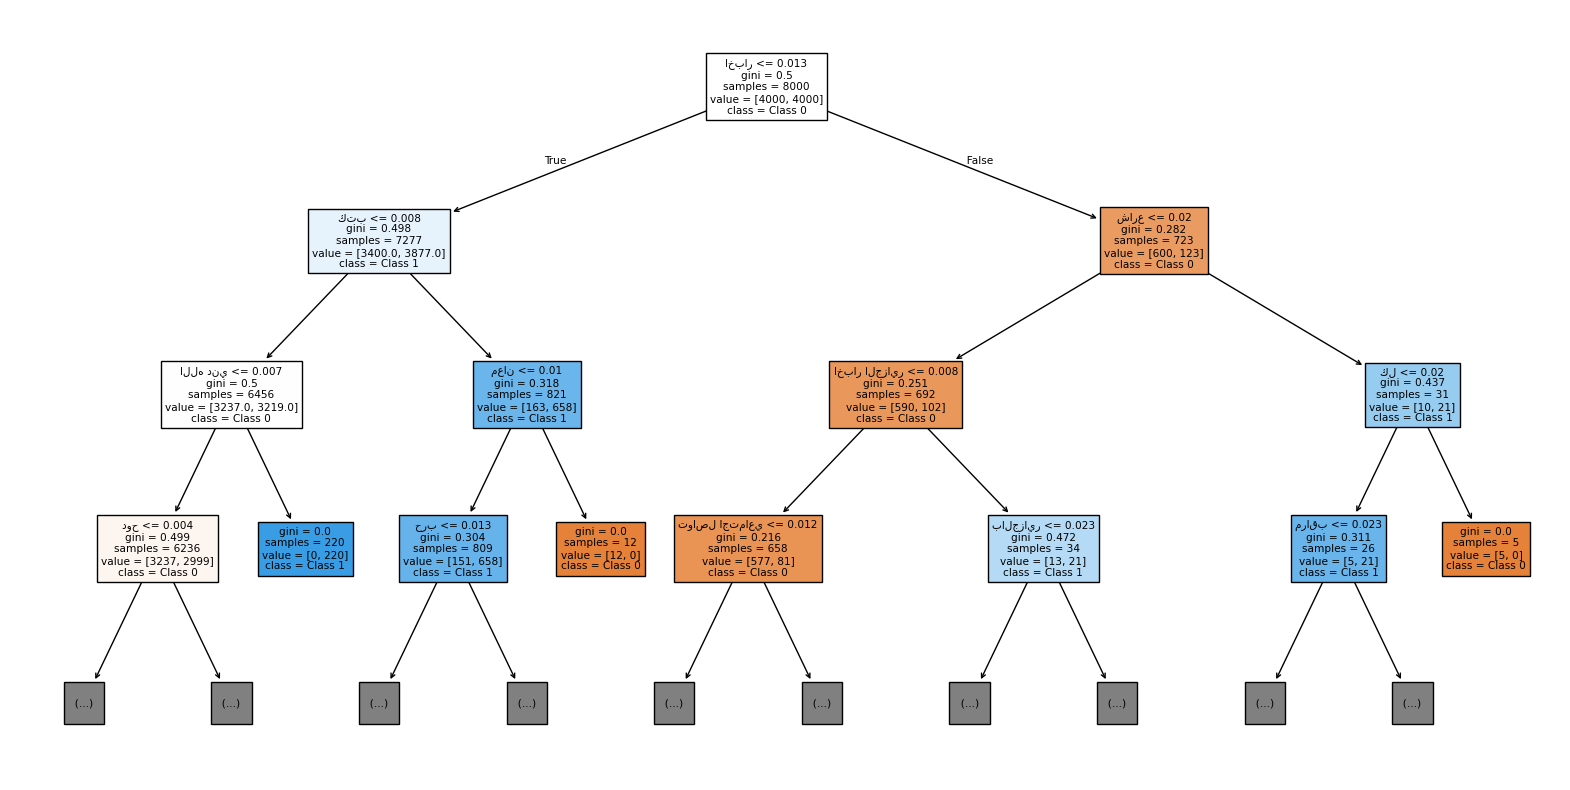

In [ ]:
# Decision Tree
dt_clf = train_and_evaluate_model(DecisionTreeClassifier(random_state=42),
                                  "Decision Tree", X_train_tfidf, y_train,
                                   X_test_tfidf, y_test, plt.cm.Greens)
plot_decision_tree(dt_clf, tfidf.get_feature_names_out(), ['Class 0', 'Class 1'])


Accuracy: 0.6975
Precision: 0.7051
Recall: 0.6790
F1 Score: 0.6918

Confusion Matrix:
 [[716 284]
 [321 679]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.72      0.70      1000
           1       0.71      0.68      0.69      1000

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



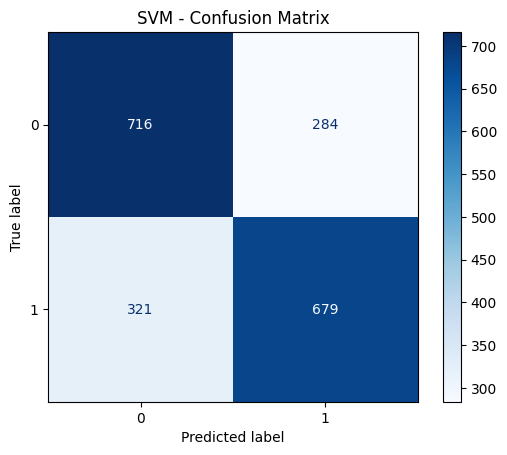

In [ ]:
# SVM
svm_clf = train_and_evaluate_model(SVC(kernel='linear', random_state=42),
                                   "SVM", X_train_tfidf, y_train,
                                   X_test_tfidf, y_test, plt.cm.Blues)


Accuracy: 0.7360
Precision: 0.7394
Recall: 0.7290
F1 Score: 0.7341

Confusion Matrix:
 [[743 257]
 [271 729]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74      1000
           1       0.74      0.73      0.73      1000

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



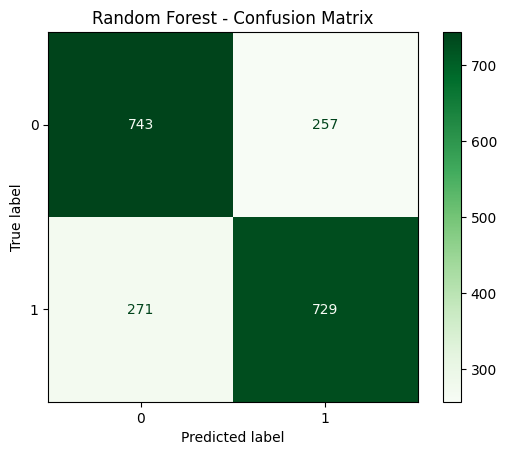

In [ ]:
# Random Forest
rf_clf = train_and_evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42),
                                  "Random Forest", X_train_tfidf, y_train,
                                  X_test_tfidf, y_test, plt.cm.Greens)


Accuracy: 0.6820
Precision: 0.6820
Recall: 0.6820
F1 Score: 0.6820

Confusion Matrix:
 [[682 318]
 [318 682]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1000
           1       0.68      0.68      0.68      1000

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



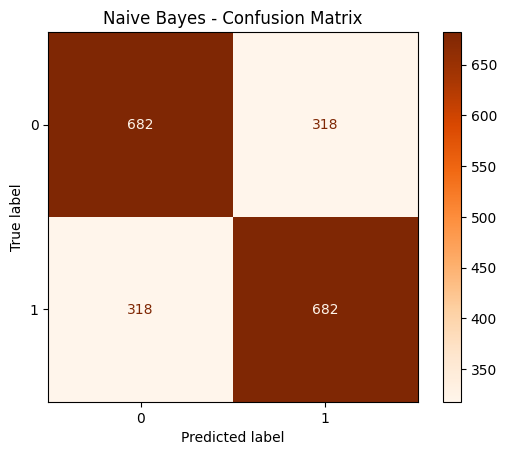

In [ ]:
# Naive Bayes
nb_clf = train_and_evaluate_model(MultinomialNB(),
                                  "Naive Bayes",  X_train_tfidf, y_train,
                                  X_test_tfidf, y_test, plt.cm.Oranges)


Accuracy: 0.7050
Precision: 0.7079
Recall: 0.6980
F1 Score: 0.7029

Confusion Matrix:
 [[712 288]
 [302 698]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      1000
           1       0.71      0.70      0.70      1000

    accuracy                           0.70      2000
   macro avg       0.71      0.70      0.70      2000
weighted avg       0.71      0.70      0.70      2000



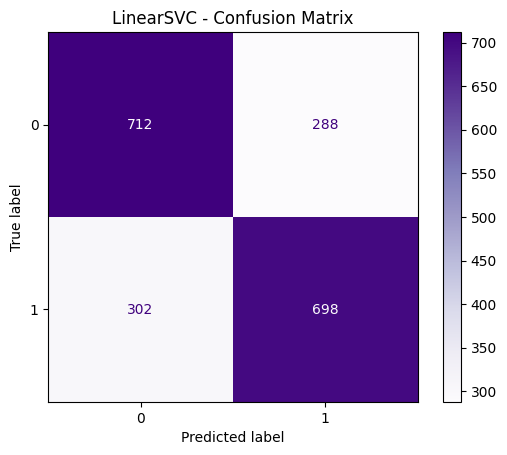

In [ ]:
# LinearSVC
linear_svc_clf = train_and_evaluate_model(LinearSVC(random_state=42),
                                          "LinearSVC",  X_train_tfidf, y_train,
                                          X_test_tfidf, y_test, plt.cm.Purples)


In [ ]:

# Get feature importances and show top 10
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 10 Important Features:")
for i in range(10):
    print(f"{vocabulary_train[indices[i]]}: {importances[indices[i]]:.4f}")



Top 10 Important Features:
كتب: 0.0156
اخبار: 0.0103
مصدر: 0.0074
اقر: 0.0060
قطر: 0.0056
رام: 0.0055
دني: 0.0052
دوح: 0.0048
هل: 0.0045
خر: 0.0042


In [ ]:
%%writefile requirements.txt
camel-tools


Writing requirements.txt


In [ ]:
!pip install -r requirements.txt


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
!camel_data -i light

/bin/bash: line 1: camel_data -i light: command not found


In [ ]:
!pip uninstall -y numpy


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [ ]:
!pip install numpy==1.26.4

In [ ]:
!pip install camel-tools

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.5/556.5 kB 30.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [ ]:
%%writefile requirements.txt
camel-tools



Writing requirements.txt


In [ ]:
!pip install -r requirements.txt

In [ ]:
!camel_data -i light

/bin/bash: line 1: camel_data -i light: command not found


In [ ]:
!camel_data -i defaults

The following packages will be installed: 'disambig-bert-unfactored-msa', 'disambig-ranking-cache-calima-msa-r13', 'ner-arabert', 'disambig-mle-calima-msa-r13', 'morphology-db-msa-r13', 'dialectid-model26', 'sentiment-analysis-arabert'
Extracting package 'disambig-bert-unfactored-msa': 100% 445M/445M [00:02<00:00, 212MB/s]
Extracting package 'disambig-ranking-cache-calima-msa-r13': 100% 556M/556M [00:01<00:00, 308MB/s]
Extracting package 'ner-arabert': 100% 542M/542M [00:01<00:00, 287MB/s]
Extracting package 'disambig-mle-calima-msa-r13': 100% 88.7M/88.7M [00:00<00:00, 365MB/s]
Extracting package 'morphology-db-msa-r13': 100% 40.5M/40.5M [00:00<00:00, 480MB/s]
Extracting package 'dialectid-model26': 100% 371M/371M [00:01<00:00, 313MB/s]
Extracting package 'sentiment-analysis-arabert': 100% 542M/542M [00:01<00:00, 327MB/s]


In [ ]:
!camel_data -i all

The following packages will be installed: 'disambig-mle-calima-egy-r13', 'disambig-bert-unfactored-glf', 'disambig-bert-unfactored-lev', 'morphology-db-glf-01', 'morphology-db-egy-r13', 'disambig-ranking-cache-calima-egy-r13', 'morphology-db-msa-s31', 'disambig-ranking-cache-calima-lev-01', 'disambig-bert-unfactored-egy', 'morphology-db-lev-01', 'disambig-ranking-cache-calima-glf-01', 'sentiment-analysis-mbert', 'dialectid-model6'
Extracting package 'disambig-mle-calima-egy-r13': 100% 27.2M/27.2M [00:00<00:00, 463MB/s]
Extracting package 'disambig-bert-unfactored-glf': 100% 442M/442M [00:01<00:00, 291MB/s]
Extracting package 'disambig-bert-unfactored-lev': 100% 441M/441M [00:01<00:00, 253MB/s]
Extracting package 'morphology-db-glf-01': 100% 7.98M/7.98M [00:00<00:00, 532MB/s]
Extracting package 'morphology-db-egy-r13': 100% 67.3M/67.3M [00:00<00:00, 352MB/s]
Extracting package 'disambig-ranking-cache-calima-egy-r13': 100% 320M/320M [00:01<00:00, 231MB/s]
Extracting package 'morphology-d

In [ ]:
!pip install arabic-reshaper

  Using cached arabic_reshaper-3.0.0-py3-none-any.whl.metadata (12 kB)
Using cached arabic_reshaper-3.0.0-py3-none-any.whl (20 kB)


In [ ]:
!pip install wordcloud

In [ ]:
!pip install python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 4.5 MB/s eta 0:00:00


In [ ]:
!apt-get install -y fonts-amiri


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package fonts-amiri


In [ ]:
import numpy as np
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# ——— Fonction de tokenisation arabe prétraitée ———
def simple_tokenizer_ar(text):
    return text.split()  # On suppose déjà normalisé/stemmé

# ——— Fonctions ATCF-IDF (comme avant) ———

def calculate_doc_freqs(docs):
    df = Counter()
    for doc in docs:
        for t in set(doc):
            df[t] += 1
    return df

def compute_idf_vector(df, n_docs, eps=1e-9):
    return { term: math.log(n_docs / (freq + eps)) for term, freq in df.items() }

def calculate_term_occurrences_in_category(term, cat, docs, categories):
    Nk = sum(1 for c in categories if c == cat)
    if Nk == 0:
        return 0.0
    count = sum(1 for d, c in zip(docs, categories) if c == cat and term in d)
    return count / Nk

def build_atcf_matrix(docs, categories, vocab):
    n_docs, n_terms = len(docs), len(vocab)
    term_to_idx = {t: i for i, t in enumerate(vocab)}
    cats = set(categories)

    occ_ratio = {}
    for t in vocab:
        for c in cats:
            occ_ratio[(t, c)] = calculate_term_occurrences_in_category(t, c, docs, categories)

    ATCF = np.zeros((n_docs, n_terms), dtype=float)
    for d_idx, (doc, cat) in enumerate(zip(docs, categories)):
        Nd = len(doc) or 1
        freqs = Counter(doc)
        for term, f in freqs.items():
            if term in term_to_idx:
                t_idx = term_to_idx[term]
                ATCF[d_idx, t_idx] = (f * occ_ratio[(term, cat)]) / Nd
    return ATCF, occ_ratio

def build_tcfidf_matrix(docs, categories):
    n_docs = len(docs)
    vocab = sorted({t for doc in docs for t in doc})
    dfreq = calculate_doc_freqs(docs)
    idf = compute_idf_vector(dfreq, n_docs)
    ATCF, occ_ratio = build_atcf_matrix(docs, categories, vocab)
    idf_vec = np.array([idf[t] for t in vocab])
    TCFIDF = ATCF * idf_vec[np.newaxis, :]
    return TCFIDF, vocab

# ——— MAIN ———

if __name__ == "__main__":
    # Phrases arabes déjà prétraitées (normalisées et stemmées)
    phrases = [
        "لقاح كورونا سبب شريح",         # fake
        "ارض مسطح",                      # fake
        "لقاح كورونا فعل",              # real
        "ماء غلي درج مئه",              # real
        "شبك  نشر فيروس"              # fake
    ]
    labels = [0,0,1,1,0]

    # Tokenisation simple (liste de mots)
    tokenized_docs = [simple_tokenizer_ar(p) for p in phrases]

    print("\n=== TF-IDF (scikit-learn) ===")
    print("Vocabulary:", tfidf_vectorizer.get_feature_names_out())

    tfidf_vectorizer = TfidfVectorizer(tokenizer=simple_tokenizer_ar, preprocessor=lambda x: x, token_pattern=None)
    tfidf_matrix = tfidf_vectorizer.fit_transform(phrases)
    print(tfidf_matrix.toarray())

    print("\n=== ATC-IDF (custom) ===")
    print("Vocabulary:", vocab)
    tcfidf_matrix, vocab = build_tcfidf_matrix(tokenized_docs, labels)
    print(tcfidf_matrix)



=== TF-IDF (scikit-learn) ===
Vocabulary: ['ارض' 'درج' 'سبب' 'شبك' 'شريح' 'غلي' 'فعل' 'فيروس' 'كورونا' 'لقاح' 'مئه'
 'ماء' 'مسطح' 'نشر']
[[0.         0.         0.55032913 0.         0.55032913 0.
  0.         0.         0.44400208 0.44400208 0.         0.
  0.         0.        ]
 [0.70710678 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.70710678 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.659118   0.         0.53177225 0.53177225 0.         0.
  0.         0.        ]
 [0.         0.5        0.         0.         0.         0.5
  0.         0.         0.         0.         0.5        0.5
  0.         0.        ]
 [0.         0.         0.         0.57735027 0.         0.
  0.         0.57735027 0.         0.         0.         0.
  0.         0.57735027]]

=== ATC-IDF (custom) ===
Vocabulary: ['ارض', 'درج', 'سبب', 'شبك', 'شريح', 'غلي', 'فعل', 'فيروس', 'كورونا', 'لقاح', 'مئه', 'ماء', 'مسط